In [2]:
# loading all the dependencies
import pandas as pd
import numpy as np
pd.options.display.float_format ='{:,.1f}'.format
import matplotlib.pyplot as plt

%matplotlib inline  
from scipy.stats import gmean
from scipy import integrate
from openpyxl import load_workbook

import uncertainties as uc
from uncertainties import ufloat
from uncertainties import unumpy
%run Utility_Functions.ipynb

## Methods and Statistics
Ranges and values with ± are given as 1 standard error of the values. 

Error bars in figure denote 1 standard error as well.


# GIT Epithelial cells

We refer to two main segments of the GI tract: small intestine and colon. We estimate the number of epithelial cell (enterocytes) lining the segments and their turnover rates, in terms of cell number and mass.

## Small intestine epithelial cells

We calculate the daily replacment rate of the small intestine epithelial cells in 3 steps:
1. Updated estimates for the cell number - in two ways:
    a. using the volume of the villi 
    b. using the surface area of the villi and crypt
2. Updated cell turnover time estimate - using data from a recent meta-anlysis  
3. Comprison to direct measurement of DNA driven from [Croft et al.,1968](http://www.thelancet.com/journals/lancet/article/PIIS0140-6736(68)90355-3/fulltext)  


### Cells number 
previous estimate vary in the range of 0.2-7x10^11 cells ( [Snyder et al.,1975](http://www.icrp.org/publication.asp?id=ICRP%20Publication%2023) , [Bianconi et al.,2003](https://www.ncbi.nlm.nih.gov/pubmed/23829164) )  
We use new data regarding the total surface area (SA) of the small intestine [Helander & Fändriks, 2014](https://www.ncbi.nlm.nih.gov/pubmed/24694282) to calculate the number of cells in two methods:
1. calculation of villi and crypt numbers, and the number of cells in each: both from a volume prespective and from surface area considerations.
2. sanity check, by dividing the total SA by a single cell SA 

### Revised estimate for total SA of small intestine
The next table shows a previous ( [Snyder et al.,1975](http://www.icrp.org/publication.asp?id=ICRP%20Publication%2023)) and a recent    ([Helander & Fändriks, 2014](https://www.ncbi.nlm.nih.gov/pubmed/24694282)) estimates for the total SA of the small intestine.

The revised values are taken from the recent [Helander & Fändriks, 2014](https://www.ncbi.nlm.nih.gov/pubmed/24694282) paper, in which, they measured the magnification factors due to each of the levels: subcellular (microvilli), cellular (villi) and morphological (plicae).They used biopsy samples to conclude that the overall surface area of the small intestine is about 30 m^2. In their paper they summerize neatly: "The total area of the human adult gut mucosa is not in the order of tennis lawn, rather is that of half a badminton court".

Notice that the table includes also the magnification factors for each of the relevant levels. Consider that the villi level is the last level relevant for the epithel cells, as microvilli are subcellular size.

In [3]:
# Load the data regarding the SA of the small intestine taken from Snyder and Helander & Fändriks.
SAdata = pd.read_excel('GIT_epithel_data.xlsx','small_intestine_SA_data',skiprows=1)
SAdata

,level,factor 1975,SA [m^2],factor 2014,revised SA [m^2]
0,cylinder approximation,1,0.3,1.0,0.2
1,Valves of Kerckring (plicae),3,1.0,1.6,0.4
2,Villi,10,10.0,6.5,2.3
3,Microvilli,20,200.0,13.0,30.3


We consider the revised surface area from 2014 at the level of the villi

In [4]:
revised_SA = SAdata.loc[SAdata['level']=='Villi']['revised SA [m^2] ']
print('revised total SA {:0.1f} squared meters'.format(revised_SA.values[0]))


revised total SA 2.3 squared meters


### Number of epithel through villi and crypts
Using the revised SA we use a method similiar to the one in [Snyder et al.,1975](http://www.icrp.org/publication.asp?id=ICRP%20Publication%2023) to calculate the number of epithel cells in the small intestine.

We first summarize available data from literature regaring humans, and several additional animals:
1. Rabbit - [Hyun et al., 1995](https://www.ncbi.nlm.nih.gov/pubmed/7797012)
2. Rat - [Tasman-James et al., 1982](https://www.ncbi.nlm.nih.gov/pubmed/6282549), [Hosoyamada et al., 2005](https://www.ncbi.nlm.nih.gov/pubmed/16044319)
3. Pig - [Lauronen et al.,1998](https://www.ncbi.nlm.nih.gov/pubmed/9517525) , [Mekbungwan et al., 2002]()
4. Dog - Krogh, 1922
5. Human - [Marsh & Swift, 1969](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1553048/), [Loehry & Creamer, 1969](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1552697/), Bohm & Von Davidoff, 1928, [Crowe et al., 1993](https://www.ncbi.nlm.nih.gov/pubmed/8333150)

In [5]:
VnCdata = pd.read_excel('GIT_epithel_data.xlsx','villi_and_crypts_data',skiprows=1,index_col=0,usecols = 'A:F')
VnCdata.head()

,rabbit,rat,pigs,dog,human
parameter,,,,,
villi height [mum],630.0,475.0,350.0,550.0,nan
villi diameter [mum],90.0,120.0,110.0,225.0,nan
villus surface area [mum2],nan,nan,0.0,"430,000.0",nan
entrocytes/villus,194.0,nan,nan,nan,nan
No. of villi /mm (1-d section),nan,nan,6.0,nan,nan


Focusing on the data regarding humans, we drop some of the less relevant parameters

In [6]:
humanVnC = VnCdata['human']
humanVnC

humanVnC = humanVnC.drop(['No. of villi /mm (1-d section)','villus density - Ileum [vill./m2]','villus density - Jejunum [vill./m2]',
                  'No. of cryptes /mm (1-d section)','epithelial cells in villi  [per mum]','villus surface area  [mum2]',
               'entrocytes/villus','villus density [vill./m2]','Crypts cells  [per mum]'])


We now use the data taken from the animals studies as estimates for the human villi's and crypt's parameters, by taking the means of the relevant data 

In [7]:
humanVnC[['villi height [mum]','villi diameter [mum]']] = VnCdata.loc[['villi height [mum]','villi diameter [mum]']].mean(axis=1)
humanVnC

parameter
villi height [mum]                      501.2
villi diameter [mum]                    136.2
crypts depths [mum]                     385.0
crypts diameter [mum]                   100.0
Crypts density [crypts/m2]                nan
epithelial cells diameter [mum]           7.5
calculated epithelial cells SA [mum2]    44.2
epithelial cell volume [mum3]           800.0
epithelial cell volume error [mum3]     150.0
crypt to villi ratio                      3.0
Name: human, dtype: float64

#### Method for enterocytes number estimations from villi and crypts data
In order to estimate the number of epithelial cell, we calculte the number of cell in each villi in two ways:
1. looking at the volume of a villous, and dividing by the volume of a single entrocytes.
2. looking at the villous surface area and dividing by the surface area if a single entrocytes.
we then multiply by the total number of villi to get a an estimate for the total number of villi entrocytes. 

For the crypts we use only the surface area method, combined with the number of crypts, given by the villi to ctrypt ratio .  

Summing the two parts we get two estimates for the number of entrocytes, which we average for a reference value.

#### villi entrocytes density calculation from volume 
we repeat the calculation from [Crosby, 1961](https://link.springer.com/article/10.1007/BF02231066) using the inside volume of the villus, that is filled with entrocytes:

we first calculate the number of entrocytes in a villus, from volume considerations:

In [8]:
villus_total_volume =  humanVnC['villi height [mum]']*np.pi*( humanVnC['villi diameter [mum]']/2)**2
villus_inside_diameter =  50 #asuming width for calculation
villus_core_volume =  humanVnC['villi height [mum]']*np.pi*(villus_inside_diameter/2)**2 #the volume surrunded by the villi
villus_cells_volume = villus_total_volume - villus_core_volume 
cells_per_villus = villus_cells_volume / humanVnC['epithelial cell volume [mum3]'] 


we then multiply by the number of villi to conclude:

In [9]:
villi_total_number = 10**7 #from Crosby
vol_villi_entrocytes = villi_total_number * cells_per_villus

print('{:0.1e} villi enterocytes'.format(vol_villi_entrocytes))

7.9e+10 villi enterocytes


#### villi  entrocytes density calculation from surface area 
We now use use the surface area to calculate the overall number of entrocytes, first in  the villi and next in the cryptes. A similiar method was used in [Bianconi et al.,2003](https://www.ncbi.nlm.nih.gov/pubmed/23829164) ) 

In [10]:
cyl_villus_SA = np.pi * humanVnC['villi height [mum]']* humanVnC['villi diameter [mum]'] #asumming cylinder

# we want to adjust the shape of the villus using data from pigs
pig_cyl_villus_SA = np.pi*VnCdata['pigs']['villi height [mum]']*VnCdata['pigs']['villi diameter [mum]']
factor_cyl2shapen = (VnCdata['pigs']['villus surface area  [mum2]']*10**12)/pig_cyl_villus_SA #[pig villus SA given in m^2
#adjusting by the factor
adj_villus_SA= factor_cyl2shapen * cyl_villus_SA

#for reference SA we take the average of both estimates
villus_SA = np.mean([adj_villus_SA, cyl_villus_SA])

#concluding the number of villi entrocytes from SA calculations
sa_cells_per_villus = villus_SA / humanVnC['calculated epithelial cells SA [mum2]'] 

sa_villi_entrocytes = villi_total_number * sa_cells_per_villus


print('{:0.1e} villi entrocytes'.format(sa_villi_entrocytes))


3.4e+10 villi entrocytes


#### crypts entrocytes density calculation from surface area 
For crypts entrocytes we use the ratio between villi and crypts to calcultae their overall SA 

In [11]:
# calculating crypt SA as cylinder and adjusting as in villi 
cyl_crypt_SA = np.pi * humanVnC['crypts depths [mum]']* humanVnC['crypts diameter [mum]'] #asumming cylinder
crypt_SA = cyl_crypt_SA * villus_SA/cyl_villus_SA

sa_cells_per_crypt = crypt_SA/humanVnC['calculated epithelial cells SA [mum2]'] 

crypts_total_number = humanVnC['crypt to villi ratio'] * villi_total_number

sa_crypt_entrocytes = crypts_total_number * sa_cells_per_crypt


print('{:0.1e} crypts entrocytes' .format(sa_crypt_entrocytes))


5.8e+10 crypts entrocytes


#### Total estimates from villi and crypt data
We use the calculations from SA and volume to conclude two seperate estimate for the number of entrocytes, that would be integrated with the next method of estimation.

In [12]:
print('{:0.1e} total entrocytes from volume estimates'.format(sa_crypt_entrocytes + vol_villi_entrocytes))
print('{:0.1e} total entrocytes from SA estimates'.format(sa_crypt_entrocytes + sa_villi_entrocytes))


1.4e+11 total entrocytes from volume estimates
9.2e+10 total entrocytes from SA estimates


#### Method for entrocytes number estimations based on data from mucosa slices
We can get another estimate using data regarding epithelial cell volume in mucaosal slices, from [Crowe et al., 1993](https://www.ncbi.nlm.nih.gov/pubmed/8333150) and [Marsh et al., 2000](https://www.ncbi.nlm.nih.gov/pubmed/21374437) 

Crowe et al. measured the volume of epithelial cells, in slices taken from muscularis mucosae.
Using their measurments of entrocyte mean volume, and the surface area of the small intestine, we can derive the number of epithelial cells in the entire small intestine. 


In [13]:
slices_area=10000 #  the area of slices thaken from the layer of the muscularis_mucosae, in µm2,
volume_of_villi_epithelium = 2.3*10**6 #in µm3, for the slice
volume_of_crypts_epithelium = 5*10**5  #in µm3, for the slice

entrocyte_mass = humanVnC['epithelial cell volume [mum3]']  

#dividing the total epithelium volume by the volume of a cell we get estimate for the number of cells in a slice
villi_entrocytes_per_area=volume_of_villi_epithelium/entrocyte_mass
crypts_entrocytes_per_area=volume_of_crypts_epithelium/entrocyte_mass

#for the muscularis_mucosae we should take in acount the sruface area including the plicae
# (SI = small intestine)
relevant_SI_surface_area = SAdata.loc[SAdata['level']=='Valves of Kerckring (plicae)']['revised SA [m^2] ']
relevant_SI_surface_area = relevant_SI_surface_area*10**12 #moving from m^2 to µm^2

slices_in_SI =relevant_SI_surface_area/slices_area

#multypling the number of cells in a slice by the number of slices we get the total number of cells
total_villi_entrocytes = slices_in_SI*villi_entrocytes_per_area
total_crypts_entrocytes = slices_in_SI*crypts_entrocytes_per_area

total_entroctes_slices = total_villi_entrocytes+total_crypts_entrocytes 

print('{:0.1e} total entrocytes estimate based on muscularis_mucosae slices' .format(total_entroctes_slices.values[0]))


1.3e+11 total entrocytes estimate based on muscularis_mucosae slices


#### Reference number of epithelial cells in the small intestine
From the three ways to calculate the number of entrocytes in the small intestine (villi and crypts data and data from mucosa slices) we get a  value of about 10^11 cells.
We save the results in a dataframe to be saved to excel later:

In [14]:
GIT = CellTypesResDF(['Stomach epithelial cells','SI epithelial cells','Colon epithelial cells'])   


SI_cells_num = np.mean([sa_crypt_entrocytes + vol_villi_entrocytes,sa_crypt_entrocytes + sa_villi_entrocytes,total_entroctes_slices])

SI_cell_delta = np.std([sa_crypt_entrocytes + vol_villi_entrocytes,sa_crypt_entrocytes + sa_villi_entrocytes,total_entroctes_slices])

GIT.res.loc['SI epithelial cells','number'] = ufloat(SI_cells_num, SI_cell_delta)

GIT.print_params('number','SI epithelial cells')

Number of SI epithelial cells is: (1.2±0.2)×10¹¹ cells


#### Sanity check for number of entrocytes - using total SA
 For reference we can compare to a value by dividing the total SA to entrocytes SA

In [15]:
cells_SA_sanity_check = revised_SA.values[0]*10**12/humanVnC['calculated epithelial cells SA [mum2]']
print('SA sanity check: {:0.1e} cells'.format(cells_SA_sanity_check)) #revised SA given in m^2


SA sanity check: 5.3e+10 cells


### Number of colon epithelial cells
To estimate the number of cells in the colon we use data regarding the areal density of crypts ([Qi et al., 2008](https://www.ncbi.nlm.nih.gov/pubmed/19021435)) together with estimates for the surface area of the colon ([Helander and Fandriks, 2014](https://www.ncbi.nlm.nih.gov/pubmed/24694282)) and the number of cell in a given crypt ([Nooteboom et al., 2010](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2816353/)) 

We use an estimates based on extrapolation from rats ([Mehl, 1991](https://www.ncbi.nlm.nih.gov/pubmed/1650408)) as a sanity check 

In [16]:
colon_data = pd.read_excel('GIT_epithel_data.xlsx','colon_properties',index_col=0, usecols = range(6))

#combining the mean value and the SD using uncertainty package
colon_data['values + SD'] =unumpy.uarray(colon_data['value'],colon_data['SD']) 

#the number of crypt is given by the multiplication of the density of crypts by the surface area
num_crypts = colon_data.loc['crypt density','values + SD']*colon_data.loc['colon surface area','values + SD']

#the total number of cells is given by the number of crypts mutplied by the number of cell in each one
GIT.res.loc['Colon epithelial cells','number'] = num_crypts*colon_data.loc['cells in crypt','values + SD']

GIT.print_params('number','Colon epithelial cells')

#for sanity check we can use the estimate from Mehl, 1991 based on extrapolation from rat:
num_from_rat = colon_data.loc['cells in rat colon','value']*colon_data.loc['man mass','value']/colon_data.loc['rat mass','value']
print('Sanity check - numebr of colon epithelial cells based on extrapolation from rat : {:0.1e}'.format(num_from_rat))


Number of Colon epithelial cells is: (6.0±2.0)×10¹⁰ cells
Sanity check - numebr of colon epithelial cells based on extrapolation from rat : 5.8e+10


### Mass of small intestine and colon epithelial cells
We use data regarding the size of small intestine enterocyte from [Crow and Marsh, 1993](https://www.ncbi.nlm.nih.gov/pubmed/8333150).
As the epithelial cells of the colon are very similar to these of the small intestine we use the same mass as reference for the colonic cells.

In [17]:
mass_density = 1.05
entrocyte_mass = ufloat(humanVnC['epithelial cell volume [mum3]'], humanVnC['epithelial cell volume error [mum3]'])*mass_density

for segment in ['SI epithelial cells', 'Colon epithelial cells']:
    GIT.res.loc[segment,'cell mass'] = entrocyte_mass
    GIT.res.loc[segment,'total cellular mass'] = entrocyte_mass*GIT.res.loc[segment,'number']/10**12
    
GIT.print_params(['cell mass','total cellular mass'],
                 ['SI epithelial cells', 'Colon epithelial cells'])

SI epithelial cells:
Cell mass of SI epithelial cells is: 840±160 pg
Total cellular mass of SI epithelial cells is: 100±20 grams
______________________________
Colon epithelial cells:
Cell mass of Colon epithelial cells is: 840±160 pg
Total cellular mass of Colon epithelial cells is: 50±20 grams


### Number and mass of stomach epithelial cells

To estimate the number of relevant epithelial cell (with fast turnover) in the stomach we use data regarding the mass composition of the stomach and the various cell types’ contribution ([Hogben et al., 1974](https://www.gastrojournal.org/article/S0016-5085(19)32700-3/fulltext))

There are several types of cells that contribute to the epithelium of the stomach. According to [Forte, 1996](https://www.springer.com/gp/book/9783642646195) most of those cells have turnover of ~40-70 days (measured in mice) and thus we focus in our estimates only on the mucous surface cells which are similar to the small intestine enterocytes and have a turnover of ~4 days (hence, when addressing stomach epithelial cells or stomach enterocyte we address them, if not mentioned else)

We use the total mass of stomach from  [ICRP, 2002](http://www.icrp.org/publication.asp?id=ICRP%20Publication%2089) ccombined with data regarding the percentage of mass contained in the stomach mucosa and especially in the relevant cells from [Hogben et al., 1974](https://www.gastrojournal.org/article/S0016-5085(19)32700-3/fulltext).


However, the data from [Hogben et al., 1974](https://www.gastrojournal.org/article/S0016-5085(19)32700-3/fulltext) is taken from the corpus which comprise only  80% of the stomach. We extrapolate for the other 20% using different assumption regarding their cellular composition, based on the fact that in these other segments:cardia and pyloric, there are no enzyme secreting cells only epithelium cells:  mucous surface and neck cells.

We get two boundaries using different assumption regarding the ratio of these types of cells and integrate them to a reference estimate for the total cellular mass of mucous surface cells, with its uncertainty.
We then use data regarding the size of mucous surface cells ([Doidge et al., 1982](https://link.springer.com/article/10.1007%2FBF00210900)) to conclude an estimate for the total number of mucous surface cells in the stomach

In [18]:
stomach_data = pd.read_excel('GIT_epithel_data.xlsx','stomach_properties',index_col=0, usecols = range(6))

stomach_data['value + SD'] = unumpy.uarray(stomach_data['value'],stomach_data['SD'])

stomach_parts = pd.DataFrame(index = ['corpus','cardia and pyloric'],
                             columns = ['total mass','mucusa mass','total mucous surface cells mass min','total mucous surface cells mass max'])

stomach_parts.loc['corpus','total mass'] = stomach_data.loc['total stomach mass','value + SD']*stomach_data.loc['gastric corpus as % of stomach weight','value + SD'] 
stomach_parts.loc['cardia and pyloric','total mass'] = stomach_data.loc['total stomach mass','value + SD']*(1-stomach_data.loc['gastric corpus as % of stomach weight','value + SD'])

stomach_parts['mucusa mass'] = stomach_parts['total mass']*stomach_data.loc['corpus mucusa as % of stomach weight','value + SD']/stomach_data.loc['gastric corpus as % of stomach weight','value + SD'] 

'''
We now what is the mass of corpus mucosa made out of mucous surface cells (~17%). In the other parts there are no cells that secret enzymes, 
but only all the cells appear to be of the mucous type. That population could contain more mucous neck cell that are more prelevant in the
gastric pits.
We have two bounderies for the % of mucous surface cells in the cardia and pyloric:
- The same percentage as in the corpus, as the secreting cells are replaced only by mucous neck cell 
- Most of the cells are mucous surface cells, as given by the ratio of mucous surface cells to mucous neck cells (knowen for the corpus).
  Their total % is given by the ratio multiplied bt the total % of mass in cells (~80% given for the corpus) 
'''
#min - using the "mucous surface cells % of corpus mucosa mass" data from the corpus
stomach_parts['total mucous surface cells mass min'] = stomach_parts['mucusa mass']*stomach_data.loc['mucous surface cells % of corpus mucosa  mass','value + SD']

#max - assuming the same ratio of surface and neck mucous cells
stomach_parts.loc['corpus','total mucous surface cells mass max']=stomach_parts.loc['corpus','total mucous surface cells mass min']

surface_to_neck_ratio = stomach_data.loc['mucous surface cells % of corpus mucosa  mass',
      'value + SD']/(stomach_data.loc['mucous surface cells % of corpus mucosa  mass','value + SD'] + stomach_data.loc['mucous neck cell % of corpus mucosa  mass','value + SD'])

stomach_parts.loc['cardia and pyloric',
     'total mucous surface cells mass max'] = stomach_parts.loc['cardia and pyloric','mucusa mass']*surface_to_neck_ratio*stomach_data.loc['total cells as %  of corpus mucosa  mass','value + SD']

#for the reference of total mucous surface cells mass we take the average of the 2 boundries
total_cell_mass=stomach_parts[['total mucous surface cells mass min','total mucous surface cells mass max']].sum().sum()/2

#we need to add the uncertainty between the two method to the uncertianty we got that arise from their internal error:
total_cell_mass_inter_unc = unumpy.nominal_values(stomach_parts[['total mucous surface cells mass min','total mucous surface cells mass max']].sum()).std()/np.sqrt(2)

#using the uncertainty package to propogate the two kind of errors:
total_cell_mass= total_cell_mass + ufloat(0,total_cell_mass_inter_unc)

#saving the total cellular mass in its designated place:
GIT.res.loc['Stomach epithelial cells','total cellular mass'] = total_cell_mass

###########
#using the reference volume of mucous surface cells to derive their total number from their total mass
#########
#assuming density 1.05 ml/g as for common cells
mass_density =1.05
GIT.res.loc['Stomach epithelial cells','cell mass'] = stomach_data.loc['volume of mucous surface cells','value + SD']*mass_density
#fl translate to pg

GIT.res.loc['Stomach epithelial cells',
            'number'] = 10**12*GIT.res.loc['Stomach epithelial cells','total cellular mass']/GIT.res.loc['Stomach epithelial cells','cell mass']

GIT.print_params(['number','cell mass','total cellular mass'],'Stomach epithelial cells')
#we refer to stomach epithelial cells = stomach mucous surface cells


Number of Stomach epithelial cells is: (1.7±0.4)×10¹⁰ cells
Cell mass of Stomach epithelial cells is: 810±90 pg
Total cellular mass of Stomach epithelial cells is: 14±3 grams


## Comaprison of cellular mass
As a sanity check, we can compare the cellular mass we estimated based on the cells number estiamte with other estimates based on the potassium content in the different segments, taken from [Snyder et al., 1975](http://www.icrp.org/publication.asp?id=ICRP%20Publication%2023), based on the formula developed by [Wang et al., 2004](https://www.ncbi.nlm.nih.gov/pubmed/14532167) that connect the fraction of cellular mass based the differences of intra/extra-cellular potassium concentrations

In [19]:
pot_data = pd.read_excel('GIT_epithel_data.xlsx','potassium_data',index_col=0, usecols = range(4))

pot_data['pottasium content'] = unumpy.uarray(pot_data['pottasium [g]'],pot_data['pottasium SD [g]'])


cellmass_conv = pd.read_excel('GIT_epithel_data.xlsx','cellular_mass_conversion',index_col=0, usecols = range(5))
cellmass_conv['val + SD']=unumpy.uarray(cellmass_conv['value'],cellmass_conv['SD'])


pot_data['cellular mass'] = 10**6*pot_data['pottasium content']*cellmass_conv.loc['cell mass/potassium conc.',
                                                                            'val + SD']/cellmass_conv.loc['potassium molar mass','val + SD']
#we multiply twice by 1000 to convert kg to g  


pot_data['epithelial cell mass fraction'] = GIT.res['total cellular mass'].values/pot_data['cellular mass']

for segment in pot_data.index:
    print('Fraction of epithelial cells out of total cellular mass in the',segment,': {:0.0fP}%'.format(100*pot_data.loc[segment,'epithelial cell mass fraction']) )



Fraction of epithelial cells out of total cellular mass in the Stomach : 29±11%
Fraction of epithelial cells out of total cellular mass in the Small intestine : 49±25%
Fraction of epithelial cells out of total cellular mass in the Colon : 49±21%


It seems to be reasnoble that about half of the cellular mass of the intestine is compose of epithelial cells, which are very dominant. In the stomach the fraction of other cells is higher as we saw earlier an hence only close to third of the cellular mass is in the epithelial cells.  

## Epithelial cells turnover time
To calculate the lifespan of the gastrointestinal epithelial cells, we use a recent meta-analysis [Darwich et al., 2014](http://dmd.aspetjournals.org/content/42/12/2016.long). We use data from the SI, for the three segments in our interest: stomach, small intestine and colon. The data is given as the results from various sources, each contains the mean value, the number of patients (N) and the method of measurement (only some include the standard deviation of the results). Each segment has data derived by two different methods.

We estimate the mean turnover of epithelial cells for each of the GIT segment in two stages:
  1. First, we aggregate the results according to the measurement methods. For each method used we derive the mean turnover measured and
       its SEM, by weighted average, considering the number of patients.
  2. In the second stage, we average the values between the two different methods (simple arithmetic mean) and propagate the errors,considering two sources of uncertainty:
           a. Intra method error - between different measurement using the same method
           b. Inter method error  - the difference between the values of the two methods
    


C:\Users\ronse\anaconda3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in true_divide
C:\Users\ronse\anaconda3\lib\site-packages\numpy\lib\function_base.py:2167: RuntimeWarning: invalid value encountered in ? (vectorized)
  outputs = ufunc(*inputs)


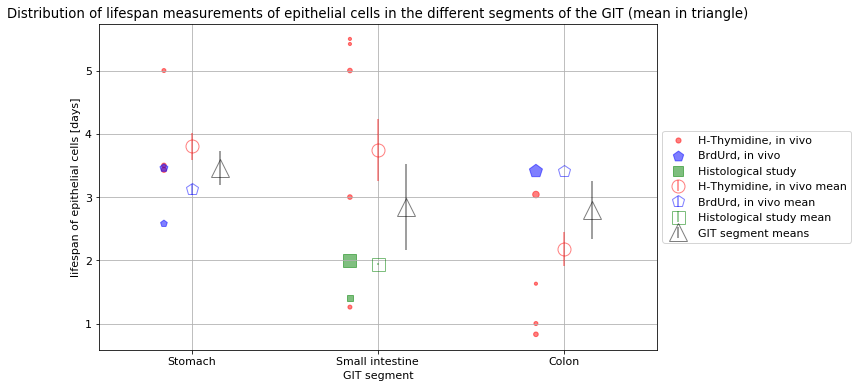

For each segment the values from the different sources is presented on the left.
The size of the point represent the number of measurements.
On the middle the mean values of each method are presented with error bars denoting 1 standard error. 
On the right the overall mean value is show with its standard error estimate.


In [25]:
# load the data from Darwich et al., 2014, SI
TOdata = pd.read_excel('GIT_epithel_data.xlsx','enterocyte_turnover',usecols = range(8))
TOdata.head()


TO2plot =  pd.DataFrame() 
TO2plot['segment']= TOdata['Segment']
TO2plot['lifespan']= TOdata['Turnover (Days)']


"""
Defining a function to extract the weighted average and std of the data, grouped by the segments of the GIT.
Based on http://stackoverflow.com/a/2415343/190597 (EOL)
"""
def weighted_average_std(grp):
    """
    Based on http://stackoverflow.com/a/2415343/190597 (EOL)
    """
    tmp = grp.select_dtypes(include=[np.number])
    weights = tmp['N']
    values = tmp.drop('N', axis=1)
    average = np.ma.average(values, weights=weights, axis=0)
    variance = np.dot(weights, (values - average) ** 2) / weights.sum()
    std = np.sqrt(variance)
    sem = np.sqrt(variance/weights.sum())
#     pd.DataFrame({'mean':average, 'std':std, 'sem':sem}, index=values.columns)
    return pd.Series(unumpy.uarray(average,sem))

# TO2plot.boxplot(by='segment',figsize= (10,5))
TO2plot['N'] = TOdata['N']

#using the defined function to extract the mean and std and then converging them to a single column using uncertainty package
TO_sum = pd.DataFrame(TO2plot.groupby('segment').apply(weighted_average_std))

#setting the sapce on the graph between the data and the averging 
WIDTH = 0.15

#usingt the caregorical properties of the panda dataframe to creat numerical coding for ploting 
TO2plot['segment'] = pd.Categorical(TO2plot['segment'])
TO2plot['x4plot'] = 3-TO2plot.segment.cat.codes-WIDTH 
#reversing the oreder: from alphabeticly (colon, small intestine, stomach) -> to descending  (stomach, small intestine ,colon) 

#defining markwer style and color for the plot
SHAPES= ['o','p', 's', '8']
COLORS =  ['r','b','g']

#defining dataframe that will contain the mean and sem of the different method for each of the segments
TO_means = pd.DataFrame(index = TOdata['Segment'].unique(), columns = TOdata['Method'].unique() )
"""
Going over the different methods and for each:
    1.computing the mean and sem of each of the segment;  
    2.plotting the data as bubbles representing the number of patients in the study;
    3.plotting error bars for the mean and sem of the method
"""
for indx,methd in enumerate(TOdata['Method'].unique()):

    #using scatter to crear a plot in which the bubles sizes represent the number of measurements in the different sources.
        plt.scatter(TO2plot['x4plot'].loc[TOdata['Method']==methd], TO2plot['lifespan'].loc[TOdata['Method']==methd],
                    c=COLORS[indx], marker=SHAPES[indx], alpha=0.5, label = methd,s=10*(TO2plot['N'].loc[TOdata['Method']==methd])**0.7 )
        
        #using the fucntion we defined to extract the mean and sems for each of the method for each of the segments
        TO_means[methd] =  TO2plot[['lifespan','segment','N']].loc[TOdata['Method']==methd].groupby('segment').apply(weighted_average_std)
        #using the function of unumpy to extract the mean and sem for the plot:
        means = unumpy.nominal_values(TO_means[methd])
        sem = unumpy.std_devs(TO_means[methd])

        #plotting the mean and sem of the method:
        plt.errorbar(range(1,4), means ,yerr =sem,marker=SHAPES[indx], ls = '',c=COLORS[indx], alpha=0.5,
                     label = methd +' mean',ms=13, mfc = 'None'  )

TO_sum=TO_sum.sort_index(ascending=False) #reversing the order of the index to get: (stomach, small intestine ,colon)

#defining the font size of the graph before updating the ticks and labels
plt.rcParams.update({'font.size': 11})
plt.xticks(range(1,4), TO_sum.index) 

plt.xlabel('GIT segment')
plt.ylabel('lifespan of epithelial cells [days]')
plt.title('Distribution of lifespan measurements of epithelial cells in the different segments of the GIT (mean in triangle)')

plt.grid()
plt.xlim((0.5,3.5))

'''
Using the means and sems we got for each of the method to compute the overall reference values for each of the GIT segments
    1. The means are given as the arithmetic mean of the mean values of the 2 relevant methods.
    2. The total SEM is given as a propogation of the intra error (the "Euclidean average" of the SEM for the two methods)
       and the inter error (between the means of the two methods, computed as STD of the two means divided by sqrt(2) )
'''
#the inrtra method variance is given by the expected varaince = mean of variance of the differebt method
intra_method_mean_and_sem = np.nanmean(TO_means,axis=1)

#the inter (between) method variance is given by the variance in the expected mean. The difference between the means of the 2 methods
bw_method_sem = np.nanstd(unumpy.nominal_values(TO_means), axis=1)/np.sqrt(2)

#using tge uncertainty packacge to propogate the two variances (intra and inter)
TO_means['total'] = intra_method_mean_and_sem + unumpy.uarray(np.zeros(3),bw_method_sem)
plt.errorbar(range(1,4)+WIDTH*np.ones(3), unumpy.nominal_values(TO_means['total']),yerr =unumpy.std_devs(TO_means['total']),
             marker='^', ls = '',c='k', alpha=0.5,label = 'GIT segment means',ms=18, mfc = 'None'  )


plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
fig = plt.gcf()
fig.set_size_inches(10, 6)


plt.show()
print('''For each segment the values from the different sources is presented on the left.
The size of the point represent the number of measurements.
On the middle the mean values of each method are presented with error bars denoting 1 standard error. 
On the right the overall mean value is show with its standard error estimate.''')

## Cellular and cellular mass turnover
Now we can combine the estimates for the number and mass of the epithelial cells with their lifespan to estimate theie total daily turnover   

In [26]:
GIT.res['lifespan'] = TO_means['total'].values
GIT.res['cellular turnover rate'] = GIT.res['number']/GIT.res['lifespan']
GIT.res['cellular mass turnover rate'] = GIT.res['total cellular mass']/GIT.res['lifespan']

GIT.print_params(['lifespan','cellular turnover rate','cellular mass turnover rate'])

Stomach epithelial cells:
Lifespan of Stomach epithelial cells is: 3.5±0.3 days
Cellular turnover rate of Stomach epithelial cells is: (5.0±1.1)×10⁹ cells per day
Cellular mass turnover rate of Stomach epithelial cells is: 4.1±0.8 grams per day
______________________________
SI epithelial cells:
Lifespan of SI epithelial cells is: 2.8±0.7 days
Cellular turnover rate of SI epithelial cells is: (4.2±1.2)×10¹⁰ cells per day
Cellular mass turnover rate of SI epithelial cells is: 35±12 grams per day
______________________________
Colon epithelial cells:
Lifespan of Colon epithelial cells is: 2.8±0.5 days
Cellular turnover rate of Colon epithelial cells is: (2.0±0.8)×10¹⁰ cells per day
Cellular mass turnover rate of Colon epithelial cells is: 17±7 grams per day


### Comparison to direct measurement
[Croft et al.,1968](http://www.thelancet.com/journals/lancet/article/PIIS0140-6736(68)90355-3/fulltext) has measured the D.N.A loss per minute from 5cm segments of the duodenum (part of the small intenstine). Assuming the D.N.A loss rate is constant across the whole small intestine, the concluded a loss of 20-50 million cells per minute
Here we use their data to compare to the daily cell turnover we have calculated.


In [27]:
dna_per_min_per_seg = 12*10**-9 #in grams
dna_per_cell = 7*10**-12 
cell_per_min_seg = dna_per_min_per_seg/dna_per_cell

seg_len = 5 #cm
SI_len = 290 #SI = small intesine. in cm

min_SI_cell_loss = (SI_len/seg_len)*cell_per_min_seg
daily_SI_cell_loss =  min_SI_cell_loss *24*60

print ('Following Croft et al.,1968, estimated daily cell loss is {:.1e} days'.format(daily_SI_cell_loss))


Following Croft et al.,1968, estimated daily cell loss is 1.4e+08 days


There is over 2 orders of magnitude difference. It seems that it indicate some problem with the the measurement method 

## Survival function and age
We use the data gather for the lifespan and transit time to plot the relevant survival function and cells age

### Survival function
We show the survival function for two different assumptions regarding the distribution of lifespan:
1. Geometric - constants probability of death (hazard)
2. Uniform - all cells die at the mean lifespan 

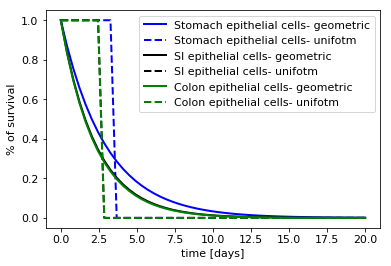

In [28]:
# Sample different time (days)
days = np.linspace(0,20)

geom_cdf = lambda n,p: 1-(1-p)**n
uni_cdf  = lambda n,max_value: 1-1*(n<max_value)


# uni_cdf  = lambda n,max_value: np.minimum(n/max_value,1)

COLORS = ['b','k','g']
Sfun_geom = np.empty([3, days.size])
Sfun_uni = np.empty([3, days.size])

for i,cell_type in enumerate(GIT.res.index): 
    mean_turnover =  GIT.res.loc[cell_type,'lifespan'].nominal_value
    Sfun_geom[i] = 1- geom_cdf(days,1/mean_turnover)
    Sfun_uni[i] = 1- uni_cdf(days,mean_turnover)

    # Plot the survival functions vs. the time
    plt.plot(days,Sfun_geom[i],c=COLORS[i],lw =2,ls = '-',label = cell_type +'- geometric')
    plt.plot(days,Sfun_uni[i],c=COLORS[i],lw =2,ls = '--',label = cell_type+'- unifotm')
plt.xlabel('time [days]')
plt.ylabel('% of survival')
plt.legend()

### Cells age
We know that the age distribution look like the survival functio, hence we can calculate the age cdf by integrating the survival function and normalize it:

Text(0, 0.5, 'age cdf')

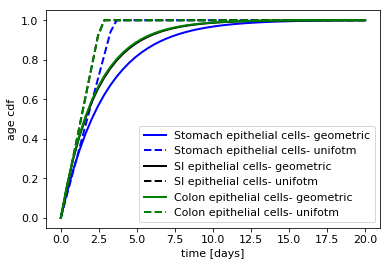

In [29]:
for i,cell_type in enumerate(GIT.res.index): 

    sf_uni_integral = integrate.cumtrapz(Sfun_uni[i], days, initial=0)
    age_cdf_uni =sf_uni_integral/max(sf_uni_integral)

    sf_geom_integral = integrate.cumtrapz(Sfun_geom[i], days, initial=0)
    age_cdf_geom = sf_geom_integral/max(sf_geom_integral)

# Plot the age functions vs. the time
    plt.plot(days,age_cdf_geom,c=COLORS[i],lw =2,ls = '-',label = cell_type +'- geometric')
    plt.plot(days,age_cdf_uni,c=COLORS[i],lw =2,ls = '--',label = cell_type +'- unifotm')
    plt.xlabel('time [days]')
    plt.ylabel('% of survival')
plt.legend()
plt.xlabel('time [days]')
plt.ylabel('age cdf')

## Saving the results to excell
So it can be used for summary 


In [30]:
GIT.res = GIT.res.rename({'SI epithelial cells':'Small intestine epithelia',
                          'Colon epithelial cells':'Colon epithelia',
                          'Stomach epithelial cells':'Stomach epithelia'})
GIT.export_to_excel('Summary.xlsx')